In [1]:
from datetime import datetime

# print date as date accessed
date_accessed = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Date accessed: {date_accessed}")

Date accessed: 2024-10-06 18:53:54


In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os, sys, glob, re, time, math, calendar

In [13]:
import dask
import dask.distributed as dd
if 'client' in locals():
    client.close()
    cluster.close()
cluster = dd.LocalCluster(n_workers=48, dashboard_address=8787)
client = dd.Client(cluster)

- One noticiable problem I encountered is loading all years dataset using mfdataset. 
- So, better read individual years, call velocity, and save that data into respective velocity.nc files

for year in range(2018,2025,1):
    files = sorted(glob.glob(f'data/profiler_request/{year}*'))
    ds = xr.open_mfdataset(files, combine='nested', concat_dim='time', parallel=True,).velocity
    ds.to_netcdf(f'data/{year}_velocity.nc')
    print(f'{year} done')

In [11]:
files = sorted(glob.glob(f'data/*.nc'))
ds = xr.open_mfdataset(files, combine='nested', concat_dim='time', parallel=True).velocity
data = ds.sel(range=slice(100,500))
data

<xarray.DataArray 'velocity' (station: 18, time: 341703, range: 17)>
dask.array<getitem, shape=(18, 341703, 17), dtype=float32, chunksize=(18, 52704, 17), chunktype=numpy.ndarray>
Coordinates:
  * station  (station) object 'PROF_ALB2' 'PROF_ALBA' ... 'PROF_WEBS'
  * range    (range) int64 100 125 150 175 200 225 ... 375 400 425 450 475 500
  * time     (time) datetime64[ns] 2018-01-01T00:05:00 ... 2024-06-30T23:55:00
Attributes:
    units:    knots

### Cheching the number of missing values across years and locations using the 5th minute as hourly data

In [3]:
for year in range(2018,2024,1):
    file = sorted(glob.glob(f'data/{year}_velocity.nc'))[0]
    ds = xr.open_dataset(file).velocity
    
    # Filter to select only data points at the 5th minute of each hour
    hourly_data = ds.sel(time=ds.time.dt.minute == 5).sel(range=slice(100, 500))
    print(f'Original times in {year}: {hourly_data.time.size}')
    # Find missing instances along the range dimension
    missing_mask = hourly_data.isnull().any(dim='range')

    # Sum missing instances for each station along the time dimension
    missing_counts = missing_mask.sum(dim='time')
    
    # insted of printing, create a pandas dataframe with years as columns and stations as rows
    if year == 2018:
        df = pd.DataFrame(missing_counts.values, columns=[year], index=missing_counts.station.values)
    else:
        df[year] = missing_counts.values

Original times in 2018: 8760
Original times in 2019: 8760
Original times in 2020: 8784
Original times in 2021: 8760
Original times in 2022: 8760
Original times in 2023: 8759


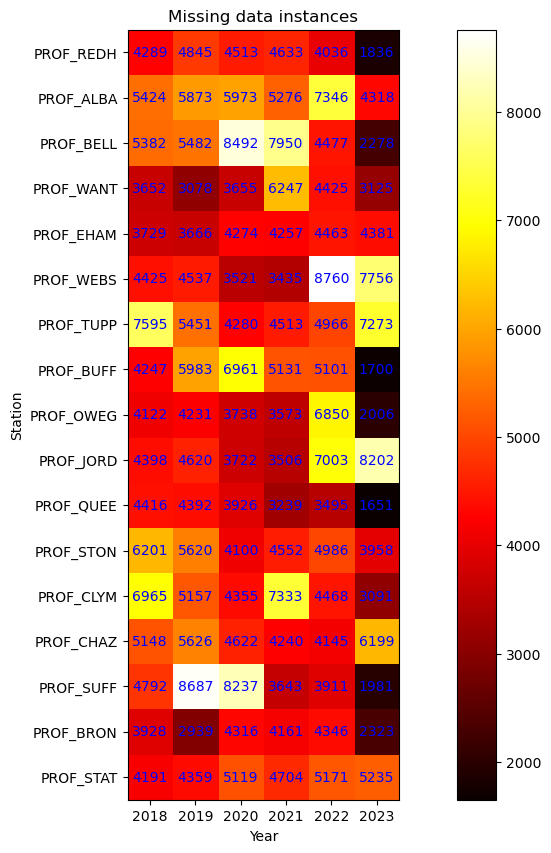

In [4]:
# now, plot a heatmap of the dataframe to visualize the missing data
plt.figure(figsize=(15,10))
plt.imshow(df, cmap='hot', interpolation='nearest')
# show values
for i in range(len(df.index)):
    for j in range(len(df.columns)):
        plt.text(j, i, df.values[i, j], ha='center', va='center', color='blue')
plt.colorbar()
plt.title('Missing data instances')
plt.xlabel('Year')
plt.ylabel('Station')
# set the x-axis labels to be the years and the y-axis labels to be the station numbers
plt.xticks(range(len(df.columns)), df.columns)
plt.yticks(range(len(df.index)), df.index)
plt.show()

### Cheching the number of missing values across years and locations using the average of 5th and 55th minutes as hourly data

In [5]:
for year in range(2018,2024,1):
    file = sorted(glob.glob(f'data/{year}_velocity.nc'))[0]
    ds = xr.open_dataset(file).velocity

    # Select data points at the 5th and 55th minute
    data_at_5th_min = ds.sel(time=ds.time.dt.minute == 5).sel(range=slice(100, 500))
    data_at_55th_min = ds.sel(time=ds.time.dt.minute == 55).sel(range=slice(100, 500))

    # Shift 5th minute data to align with the previous hour's 0th minute
    data_at_5th_min['time'] = data_at_5th_min.time - pd.Timedelta(minutes=5)
    # Shift 55th minute data to align with the next hour's 0th minute
    data_at_55th_min['time'] = data_at_55th_min.time + pd.Timedelta(minutes=5)

    # Combine the two, averaging where both exist
    hourly_data = (data_at_5th_min + data_at_55th_min) / 2

    # Find missing instances along the range dimension
    missing_mask = hourly_data.isnull().any(dim='range')

    # Sum missing instances for each station along the time dimension
    missing_counts = missing_mask.sum(dim='time')
    
    # insted of printing, create a pandas dataframe with years as columns and stations as rows
    if year == 2018:
        df = pd.DataFrame(missing_counts.values, columns=[year], index=missing_counts.station.values)
    else:
        df[year] = missing_counts.values

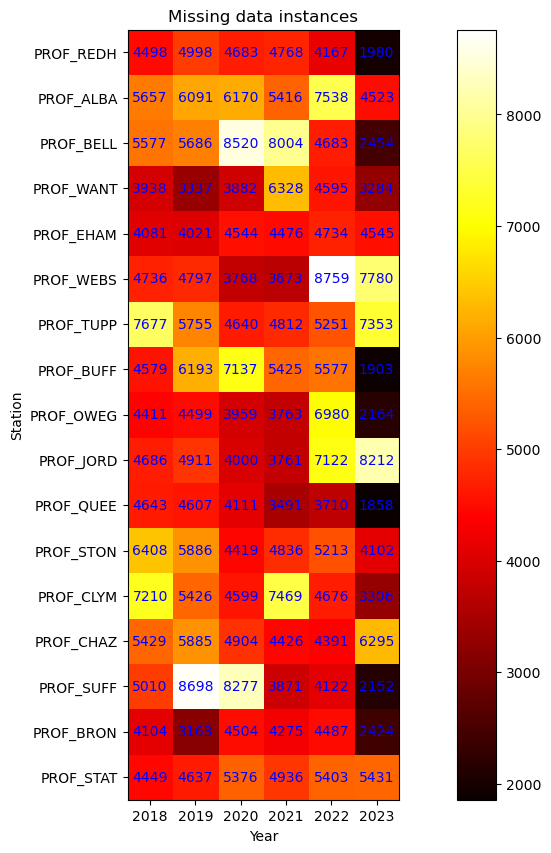

In [6]:
# now, plot a heatmap of the dataframe to visualize the missing data
plt.figure(figsize=(15,10))
plt.imshow(df, cmap='hot', interpolation='nearest')
# show values
for i in range(len(df.index)):
    for j in range(len(df.columns)):
        plt.text(j, i, df.values[i, j], ha='center', va='center', color='blue')
plt.colorbar()
plt.title('Missing data instances')
plt.xlabel('Year')
plt.ylabel('Station')
# set the x-axis labels to be the years and the y-axis labels to be the station numbers
plt.xticks(range(len(df.columns)), df.columns)
plt.yticks(range(len(df.index)), df.index)
plt.show()

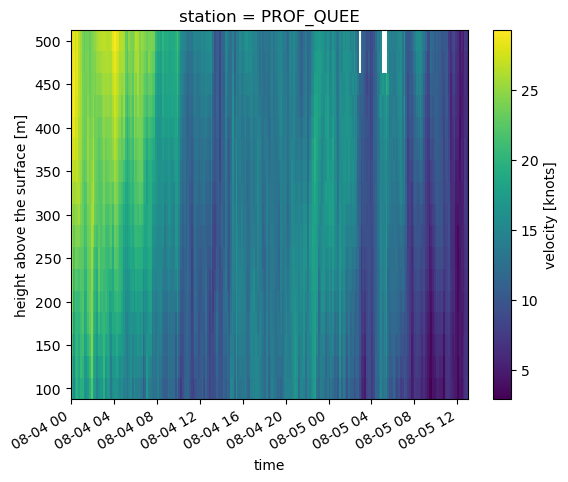

In [23]:
ds.sel(station='PROF_QUEE').sel(range=slice(100,500),time=slice('2023-08-04T00','2023-08-05T12')).T.plot()